In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from skimage.color import ycbcr2rgb
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from scipy import signal
from scipy import misc # pip install Pillow
# import imageio
import matplotlib.pylab as pylab
from PIL import Image
import tarfile
import bz2
from zipfile import ZipFile

%matplotlib inline
pylab.rcParams['figure.figsize'] = (20.0, 7.0)

In [3]:
def MSE(original, compressed):
    return np.mean((original - compressed)**2)

def PSNR(original, compressed, num_pixels=255.0):
    mse = MSE(original,compressed)
    if mse == 0:
        return float('inf')
    return 10.0 * np.log10( num_pixels**2 / mse)

In [4]:
def EE123_psnr(ref, meas, maxVal=255):
    assert np.shape(ref) == np.shape(meas), "Test image must match measured image dimensions"
        
    
    dif = (ref.astype(float)-meas.astype(float)).ravel()
    mse = np.linalg.norm(dif)**2/np.prod(np.shape(ref))
    psnr = 10*np.log10(maxVal**2.0/mse)
    return psnr

In [5]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [6]:
def zero_pad(img):

    new_img = img
    
    if img.shape[0] % 8 != 0:
        zeros = np.zeros((8 - img.shape[0] % 8,img.shape[1],img.shape[2]))
        new_img = np.vstack((img,zeros))

    temp = new_img

    if img.shape[1] % 8 != 0:
        zeros = np.zeros((new_img.shape[0],8 - img.shape[1] % 8,new_img.shape[2]))
        temp = np.hstack((new_img,zeros))
        print(new_img.shape)

    return temp

In [18]:
### for now using basic common matrix 

Ql = np.array( [[16,12,14,14,18, 24, 49, 72],
                [11, 12, 13, 17, 22, 35, 64, 92],
                [10, 14, 16, 22, 37, 55, 78, 95],
                [16, 19, 24, 29, 56, 64, 87, 98],
                [24, 26, 40, 51, 68, 81, 103, 112],
                [40, 58, 57, 87, 109, 104, 121, 100],
                [51, 60, 69, 80, 103, 113, 120, 103],
                [61, 55, 56, 62, 77, 92, 101, 99]]
                ).T

Qc = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
              [18, 21, 26, 66, 99, 99, 99, 99],
              [24, 26, 56, 99, 99, 99, 99, 99],
              [47, 66, 99, 99, 99, 99, 99, 99],
              [99, 99, 99, 99, 99, 99, 99, 99],
              [99, 99, 99, 99, 99, 99, 99, 99],
              [99, 99, 99, 99, 99, 99, 99, 99],
              [99, 99, 99, 99, 99, 99, 99, 99]]).T



def helper_divide(A,Q):
    
    Y = np.zeros((8,8))
    for u, v in [(u, v) for u in xrange(8) for v in xrange(8)]:
        Y[u, v] = round(A[u, v] / Q[u, v])

    return Y 
def helper_mul(A,Q):
    
    Y = np.zeros((8,8))
    for u, v in [(u, v) for u in xrange(8) for v in xrange(8)]:
        Y[u, v] = A[u, v] * Q[u, v]

    return Y 

def quantize(U, q = 50.):

    s = U.shape
    Y = np.zeros(s)

    if q <= 50 and q > 0:

        alpha = 50.0 / q
    else:
        alpha = 2 - q / 50.0

    for i in r_[:U.shape[0]:8]:
        for j in r_[:U.shape[1]:8]:
            Y[i:(i+8),j:(j+8),0] = helper_divide(U[i:(i+8),j:(j+8),0], Ql)
#             Y[i:(i+8),j:(j+8),0] = (U[i:(i+8),j:(j+8),0] // (Ql))
    for k in range(1,3):
        for i in r_[:U.shape[0]:8]:
            for j in r_[:U.shape[1]:8]:
                Y[i:(i+8),j:(j+8),k] = helper_divide(U[i:(i+8),j:(j+8),k], alpha*Qc)
#                 Y[i:(i+8),j:(j+8),k] = (U[i:(i+8),j:(j+8),k] // (alpha*Qc))
#     print(U[:8,:8,0])
#     print(Y[:8,:8,0])
    
#     print(U[:8,:8,1])
#     print(Y[:8,:8,1])
    

    return Y

def iquantize(U, q=50.):
    
    s = U.shape
    Y = np.zeros(s)
    
    if q <= 50 and q>= 1:
        alpha = 50./q
    else:
        alpha = 2-q/50.0
    
    for i in r_[:U.shape[0]:8]:
        for j in r_[:U.shape[1]:8]:
#             Y[i:(i+8),j:(j+8),0] = (U[i:(i+8),j:(j+8),0] * (Ql))
            Y[i:(i+8),j:(j+8),0] = helper_mul(U[i:(i+8),j:(j+8),0], alpha*Ql)
    for k in range(1,3):
        for i in r_[:U.shape[0]:8]:
            for j in r_[:U.shape[1]:8]:
                Y[i:(i+8),j:(j+8),k] = helper_mul(U[i:(i+8),j:(j+8),k], alpha*Qc)
#                 Y[i:(i+8),j:(j+8),k] = (U[i:(i+8),j:(j+8),k] * (alpha* Qc))

#     print(U[:8,:8,0])
#     print(Y[:8,:8,0])
    
#     print(U[:8,:8,1])
#     print(Y[:8,:8,1])
    
    return Y



In [19]:
def get_size(img_path):
    statinfo = os.stat(img_path)
    print("size of file = " + str(statinfo.st_size) + " Bytes")


In [20]:
rgb_to_YCbCr = np.array([[0.29900, 0.58700, 0.11400],
                       [-0.16874, -0.33126, 0.50000],
                       [0.50000, -0.41869, -0.08131]])

YCbCr_to_rgb = np.linalg.inv(rgb_to_YCbCr)

def rgb2YCbCr(U):
    s = U.shape

    Y = np.zeros(s)
    for i in range(s[0]):
        for j in range(s[1]):

            Y[i,j] = np.dot(rgb_to_YCbCr,U[i,j]) + np.array([[0],[128],[128]])[:,0]
    return Y



def YCbCr2rgb(U):
    s = U.shape
    Y = np.zeros(s)
    for i in range(s[0]):
        for j in range(s[1]):
            Y[i,j] = np.dot(YCbCr_to_rgb,U[i,j] -  np.array([[0],[128],[128]])[:,0]) 
    return Y


In [21]:
def zipping(img,min_val,max_val,beta,og_shape,img_name):


    output = open("rec_info.txt", "w")
    output.write(img_name + "|" + str(og_shape[0]) + "|" + str(og_shape[1]) + "|" + str(og_shape[2])+ "|" + str(min_val) + "|" + str(max_val) + "|" + str(beta))
    output.close()

    ##save Image 
    scipy.misc.imsave("rec.tiff",np.uint8(img))


    
    # ##Encode Image 

    tar = tarfile.open("rec.tar.bz2", "w:bz2")
#     tar = tarfile.open("rec.tar.gz", "w:gz")
    tar.add("rec.tiff")
    tar.add("rec_info.txt")
    
    tar.close()

    
    compressed_img_bytes = os.stat("rec.tar.bz2").st_size
#     compressed_img_bytes = os.stat("rec.tar.gz").st_size
    print(compressed_img_bytes)
    if (compressed_img_bytes > 75 * 1200):
        print("Zipped File Too Big! " + str(compressed_img_bytes) + " Bytes")
    print("image zipped")

    return min_val, max_val


def unzipping():

    ## Unpack 
#     tar = tarfile.open("rec.tar.bz2", "r:bz2")
#     tar = tarfile.open("rec.tar.gz", "r:gz")
#     tar.extractall()
#     tar.close()
    
    
    info = open("rec_info.txt", "r")
    info = info.read()
    info = info.split("|")
    print(info)
    
    img_name = info[0]
    og_shape = (int(info[1]),int(info[2]),int(info[3]))
    min_val = info[4]
    try:
        min_val = float(min_val)
    except:
        min_val = True
    
    max_val = float(info[5])
    beta = float(info[6])
    

    r = Image.open("rec.tiff")
    r = np.array(r)
    if min_val != True:
        r = ((r * max_val)/ 255) + min_val
    
    
    print("image unzipped")
    r = r.astype(int)
#     print(r)
    return r, img_name, og_shape, min_val, max_val, beta


def encode(raw_str):
    comp_file = StringIO.StringIO()
    with zipfile.ZipFile(comp_file, mode='w', compression=zipfile.ZIP_DEFLATED) as z:
        z.writestr('comp', raw_str)
    return comp_file.getvalue()

def decode(enc_str):
    if test: return enc_str
    comp_file = StringIO.StringIO(enc_str)
    with zipfile.ZipFile(comp_file, mode='r') as z:
        return z.read('comp')


In [22]:
def compress_image(img, thresh, q,img_name,og_shape, modem_bw = 1200 * 75,do_quantize = True):
    
    
    img = zero_pad(img)
    img = img[::2]
    og_bytes = os.stat(img_name).st_size
    C = 3000
    min_val = max_val = 0
    
    if og_bytes < modem_bw:
        print("returned original")
        min_val = True
        return img, min_val, max_val
     

#     img = np.array(img.convert("YCbCr"))
    img = rgb2YCbCr(img)


    imsize = img.shape
    dct = np.zeros(imsize)

    
    # Do 8x8 DCT on image (in-place)
    for i in r_[:imsize[0]:8]:
        for j in r_[:imsize[1]:8]:
            dct[i:(i+8),j:(j+8)] = dct2( img[i:(i+8),j:(j+8)] )

        
            
    # Threshold
    if  thresh != 0:
        print("thresholding")
        dct_thresh = dct * (abs(dct) > (thresh*np.max(dct)))
    else: 
        dct_thresh = dct
    


    #Quantization
    if do_quantize == True:
        
        print("quantizing")
        dct_thresh = (quantize(dct_thresh,q))
        min_val = 0

        if np.min(dct_thresh) < 0:
            min_val = np.min(dct_thresh)
            dct_thresh += abs(np.min(dct_thresh))

        max_val = np.max(dct_thresh)

        dct_thresh = dct_thresh /  np.max(dct_thresh)
        dct_thresh *= 255
    else:
        print("returned thresholded")
        return dct_thresh, min_val, max_val 
        
        

        
    print("Size of compressed image: " + str(dct_thresh[np.nonzero(dct_thresh)].nbytes) + " Bytes")
    print("Size of original image: " + str(img.nbytes) + " Bytes")
    print("Precent Compression: " + str(100.*img.nbytes / dct_thresh[np.nonzero(dct_thresh)].nbytes) + "%")
    
    percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (dct_thresh.shape[0]*dct_thresh.shape[1]*dct_thresh.shape[2]*1.0)
    print ("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
    
    
    return dct_thresh, min_val,max_val

In [23]:
def recon_image(dct_im,  original,q,min_val,max_val, og_shape):

    if min_val == True:
        cropped_img = dct_im[:og_shape[0],:og_shape[1],:og_shape[2]]
        return cropped_img
        

    
    if max_val != 0:
        #Inverse Quantization
        print("Inverse Quantize")
        dct_im = iquantize(dct_im,q)
    

    recon_im = np.zeros(dct_im.shape)

    for i in r_[:dct_im.shape[0]:8]:
        for j in r_[:dct_im.shape[1]:8]:
            recon_im[i:(i+8),j:(j+8)] = idct2( dct_im[i:(i+8),j:(j+8)] )

    recon_im = scipy.misc.imresize(recon_im, og_shape, interp='bilinear', mode=None)

#     rgb_im = Image.fromarray(recon_im.astype(int),mode="YCbCr").convert("RGB")
    rgb_im = np.uint8(YCbCr2rgb(recon_im))

    ##cropping the image to fit original size

    
    rgb_im[np.where(rgb_im > 255)] = 255
    rgb_im[np.where(rgb_im < 0)] = 0
    rgb_im = np.uint8(rgb_im)
    
    
    cropped_img = rgb_im[:og_shape[0],:og_shape[1],:og_shape[2]]
    
#     plt.figure()
#     plt.imshow( np.hstack((original,cropped_img)))
#     plt.title("Comparison between original, DCT compressed images" )
    
    return cropped_img

In [24]:
# ##
# img = misc.imread("pauly.tiff")
# img_name = "pauly.tiff"
# original = misc.imread("pauly.tiff")

##
# img = misc.imread("imagetypes_smoothimage.tiff")
# img_name = "imagetypes_smoothimage.tiff"
# original = misc.imread("imagetypes_smoothimage.tiff")

# img = misc.imread("bitmap1.tiff")
# img_name = "bitmap1.tiff"
# original = misc.imread("bitmap1.tiff")



# ##
# img = misc.imread("Isee.tiff")
# img_name = "Isee.tiff"
# original = misc.imread("Isee.tiff")

##
img = misc.imread("createrLake.tiff")
img_name = "createrLake.tiff"
original = misc.imread("createrLake.tiff")


##
# img = misc.imread("Marconi.tiff")
# original = misc.imread("Marconi.tiff")
# img_name = "Marconi.tiff"

##
# img = misc.imread("calBlue.tiff")
# original = misc.imread("calBlue.tiff")
# img_name = "calBlue.tiff"

##


# img_name = "Marconi.tiff"
# img = Image.open("Isee.tiff")


In [283]:



beta = 50.
og_shape = img.shape
print(og_shape)

##compress Image 
rec,min_val, max_val = compress_image(img, 0,beta,img_name, og_shape,do_quantize=True)
zipping(rec,min_val,max_val,beta,og_shape,img_name)

# zipping(img,True,0,beta,og_shape,img_name)




##info to transmit 
# msg = (rec,minVal,maxVal,beta,og_shape)

(432, 1200, 3)
quantizing
Size of compressed image: 6220784 Bytes
Size of original image: 6220800 Bytes
Precent Compression: 100.000257202%
Keeping only 99.999743% of the DCT coefficients
47766
image zipped


(-51.0, 178.0)

['EE_test.tiff', '72', '110', '3', 'True', '0', '50.0']
image unzipped


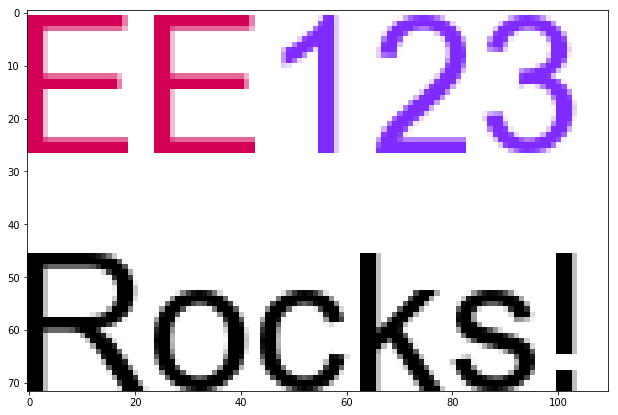

In [26]:

##Reconstruct Image 


rec, img_name, og_shape, min_val, max_val, beta = unzipping()
# print(og_shape)

recon_im = recon_image(rec,img, beta,min_val,max_val,og_shape)
# recon_im = recon_image(rec,img, beta,True,max_val,og_shape)
   
plt.imshow( np.uint8(recon_im))
scipy.misc.imsave("recon_im.tiff", recon_im)
# print("PSNR: " + str(PSNR(img,recon_im)) + "db")

In [27]:
### Problems ###
np.save('rec_EE_test.tiff', recon_im)


/Users/benbenzour/anaconda2/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


PSNR: 37.5894176171db


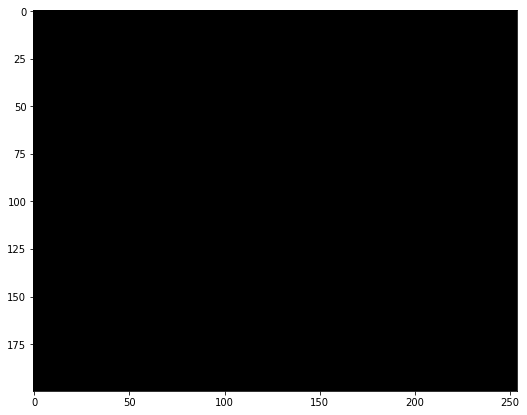

In [242]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float, color
from skimage.util import random_noise

i = denoise_tv_chambolle(recon_im, weight=0.1, multichannel=True)
# i = denoise_wavelet(recon_im, multichannel=True)
# i = denoise_wavelet(recon_im, multichannel=True, convert2ycbcr=True)


i *=255
i = np.uint8(i)

print("PSNR: " + str(PSNR(original,i)) + "db")
plt.imshow( i)

In [296]:
img = misc.imread("EE_test.tiff")
# img = misc.imread("mid_test.tiff")


PSNR: infdb


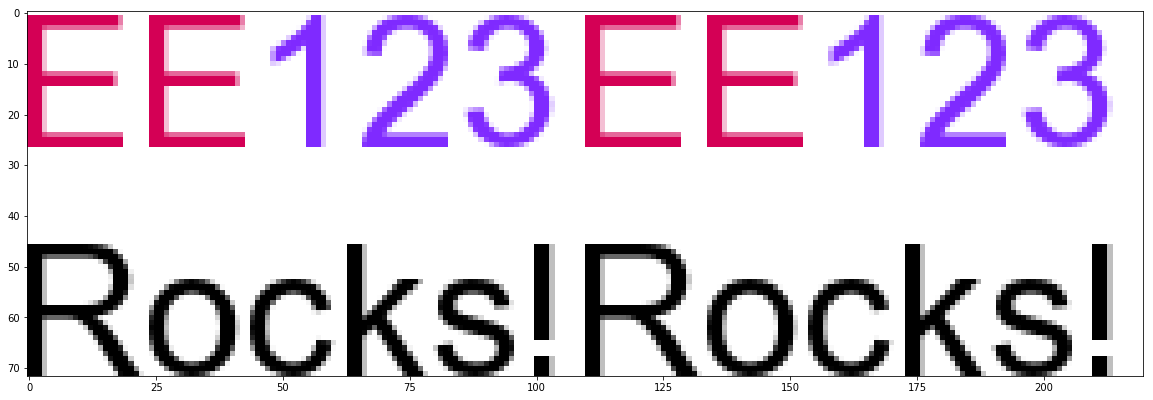

In [300]:
print("PSNR: " + str(PSNR(img,recon_im)) + "db")
plt.imshow( np.hstack((img, np.uint8(recon_im))))

['mid_test.tiff', '346', '768', '3', '-42.0', '162.0', '50.0']
image unzipped
Inverse Quantize


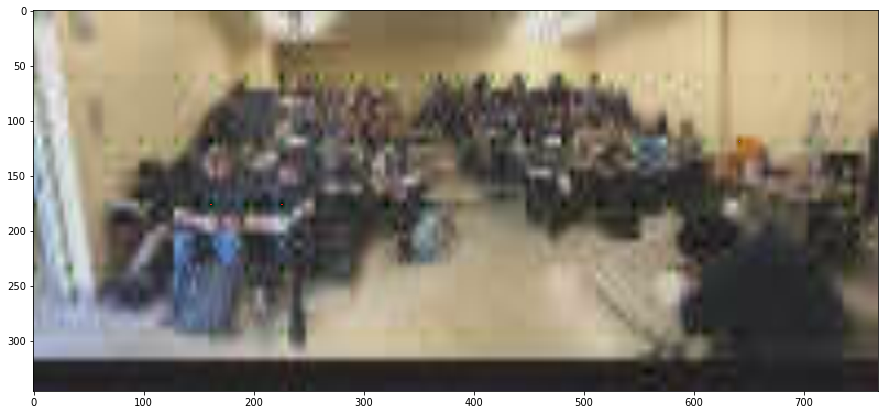

In [16]:

rec, img_name, og_shape, min_val, max_val, beta = unzipping()
# print(og_shape)

recon_im = recon_image(rec,img, beta,min_val,max_val,og_shape)
# recon_im = recon_image(rec,img, beta,True,max_val,og_shape)
   
plt.imshow( np.uint8(recon_im))
scipy.misc.imsave("recon_im.tiff", recon_im)
# print("PSNR: " + str(PSNR(img,recon_im)) + "db")

In [306]:
img = misc.imread("mid_test.tiff")

PSNR: 27.9664427103db
12.446784964


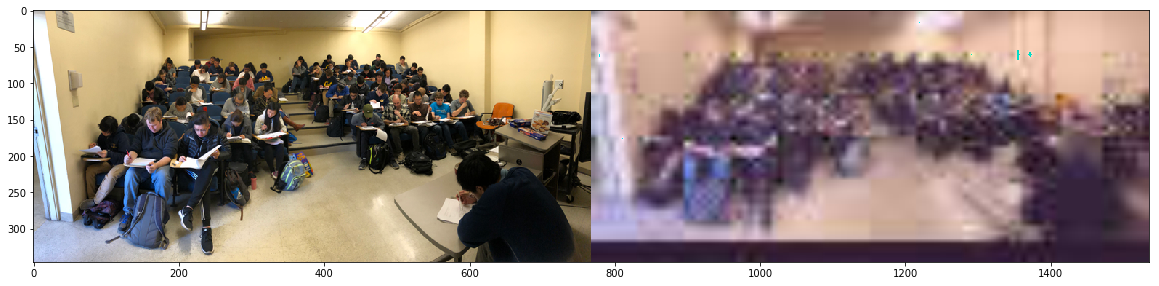

In [308]:
# print("PSNR: " + str(PSNR(img,recon_im)) + "db")
print(EE123_psnr(img,recon_im))
plt.imshow( np.hstack((img, np.uint8(recon_im))))

In [17]:
# rec, img_name, og_shape, min_val, max_val, beta = unzipping()
# print(og_shape)

# recon_im = recon_image(rec,img, beta,min_val,max_val,og_shape)
# recon_im = recon_image(rec,img, beta,True,max_val,og_shape)
   
# plt.imshow( np.uint8(recon_im))
np.save('rec_mid_test.tiff', recon_im)
# scipy.misc.imsave("recon_im.tiff", recon_im)
# print("PSNR: " + str(PSNR(img,recon_im)) + "db")